## Import

In [1]:
import os
pwd = os.path.abspath('.')
os.chdir(os.path.join(pwd, '../src/'))

In [2]:
from collections import Counter
import pandas as pd
import seaborn as sns
from core.environment import EnvironmentSettings
from string import Template
from core.column_definition import BaseColumns, CalculatedColumns

import datetime

c:\Users\NRohra\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%load_ext autoreload
%autoreload 2

## Setup

#### Import Common Classes

In [4]:
from calculations.base import PriceCrossedAboveValueFlagWorker, PriceCrossedBelowValueFlagWorker

#### Helpers

In [5]:
def get_fwd_looking_price_cols(data: pd.DataFrame):
  return [x for x in data.columns if 'HighestPercFallInNext' in x], \
    [x for x in data.columns if 'HighestPercRiseInNext' in x]

#### Historical Data Processor 

In [6]:
from datareader.data_reader import NseIndicesReader
reader = NseIndicesReader()

from datareader.data_reader import MultiDatesDataReader, DateRangeDataReader

multidates_reader = MultiDatesDataReader(reader)
daterange_reader = DateRangeDataReader(reader)

from core.core import MarketDaysHelper, TypeHelper

In [7]:
yest = datetime.date.today() + datetime.timedelta(days=-1)

In [8]:
from dataprocess.data_processor import HistoricalDataProcessor, MultiDataCalculationPipelines, CalculationPipelineBuilder, HistoricalDataProcessOptions
from calculations.equity import IsInDerivativesFlagCalculationWorker
from calculations.base import DatePartsCalculationWorker, VwapCalculationWorker
options = HistoricalDataProcessOptions()
options.include_monthly_data = False
options.include_annual_data = False
histDataProcessor = HistoricalDataProcessor(options)

In [29]:
year_start = datetime.date(1990, 1, 1)
to_date = yest
result = histDataProcessor.process(reader, {'from_date': year_start, 'to_date': to_date})

Started to read data
Reading from 2013-01-01 instead of 1990-01-01
get_data took 1 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 0 seconds
process took 2 seconds


In [10]:
from datareader.data_reader import NseIndicesReader
reader = NseIndicesReader()

from datareader.data_reader import DateRangeDataReader
daterange_reader = DateRangeDataReader(reader)

from_date = datetime.date(2023, 1, 1)
to_date = datetime.date.today() + datetime.timedelta(days=-1)
result = daterange_reader.read(from_date = from_date, to_date = to_date)

https://archives.nseindia.com/content/indices/ind_close_all_17112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_20112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_21112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_22112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_23112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_24112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_28112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_29112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_30112023.csv
https://archives.nseindia.com/content/indices/ind_close_all_01122023.csv
https://archives.nseindia.com/content/indices/ind_close_all_04122023.csv
https://archives.nseindia.com/content/indices/ind_close_all_05122023.csv
https://archives.nseindia.com/content/indices/ind_close_all_06122023.csv
https://archives.nseindia.com/content/indices/ind_c

In [30]:
daily_data = result.get_daily_data()
daily_data[[BaseColumns.Open, BaseColumns.High, BaseColumns.Low, BaseColumns.Close]] = daily_data[[BaseColumns.Open, BaseColumns.High, BaseColumns.Low, BaseColumns.Close]].replace('-', 'NaN').astype(float)
daily_data[BaseColumns.High].fillna(daily_data[BaseColumns.Close], inplace=True)

In [31]:
daily_data[BaseColumns.PreviousClose] = daily_data.groupby(BaseColumns.Identifier)[BaseColumns.Close].transform(lambda x: x.diff(-1))
daily_data[BaseColumns.Volume] = 0

In [47]:
pipelines = MultiDataCalculationPipelines()
periods = [1, 7, 15, 30, 45]
pipelines.set_item('date_parts', CalculationPipelineBuilder.create_pipeline_for_worker(DatePartsCalculationWorker()))
pipelines.set_item('sma', CalculationPipelineBuilder.create_sma_calculation_pipeline())
#pipelines.set_item('vwap', CalculationPipelineBuilder.create_pipeline_for_workers([VwapCalculationWorker(14), PriceCrossedAboveValueFlagWorker(CalculatedColumns.Vwap)]))
pipelines.set_item('rsi', CalculationPipelineBuilder.create_rsi_calculation_pipeline())
pipelines.set_item('stoch_rsi', CalculationPipelineBuilder.create_stoch_rsi_calculation_pipeline())
pipelines.set_item('bb', CalculationPipelineBuilder.create_bb_calculation_pipeline())
pipelines.set_item('foward_looking_fall', CalculationPipelineBuilder.create_forward_looking_price_fall_pipeline(periods))
pipelines.set_item('foward_looking_rise', CalculationPipelineBuilder.create_forward_looking_price_rise_pipeline(periods))

histDataProcessor.set_calculation_pipelines(pipelines)

In [48]:
histDataProcessor.run_calculation_pipelines()

DatePartsCalculationWorker took 3 seconds
SMACalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
SMACalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
SMACalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
RsiCalculationWorker took 2 seconds
ValueCrossedAboveFlagWorker took 0 seconds
ValueCrossedBelowFlagWorker took 0 seconds
StochRsiCalculationWorker took 2 seconds
ValueCrossedAboveFlagWorker took 0 seconds
ValueCrossedAboveFlagWorker took 0 seconds
ValueCrossedBelowFlagWorker took 0 seconds
ValueCrossedBelowFlagWorker took 0 seconds
StdDevCalculationWorker took 0 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBe

In [50]:
daily_data = result.get_daily_data()

In [52]:
daily_data['ATH'] = daily_data.groupby(BaseColumns.Identifier)[BaseColumns.High].transform(lambda x: 
  x.expanding().max().shift(-30)
)
daily_data['IsATH'] = daily_data['ATH'] == daily_data[BaseColumns.High]
highest_fall_cols, highest_rise_cols = get_fwd_looking_price_cols(daily_data)

In [37]:
out_cols = TypeHelper.get_class_static_values(BaseColumns) + highest_fall_cols
file_suffix = datetime.date.today().strftime('%d-%m-%Y')
daily_data[
  (daily_data[BaseColumns.Identifier] == 'NIFTY 50')
  &
  (daily_data['IsATH'] == True)
][out_cols].to_csv(f'../output/temp/index-data-{file_suffix}.csv')

In [38]:
daily_data[
  (daily_data[BaseColumns.Identifier] == 'NIFTY 50')
  &
  (daily_data['Year'] == 2017)
  &
  (daily_data['Month'] == 'Aug')
].head(1)

,Identifier,Index Date,Open,High,Low,Close,Points Change,Change(%),Volume,Turnover (Rs. Cr.),...,Bb200Dev2Upper,Bb200Dev2Lower,PriceCrossedBelowBb200Dev2Lower,PriceCrossedAboveBb200Dev2Upper,Bb200Dev3Upper,Bb200Dev3Lower,PriceCrossedBelowBb200Dev3Lower,PriceCrossedAboveBb200Dev3Upper,ATH,IsATH
142128,NIFTY 50,01-08-2017,10101.05,10128.6,10065.75,10114.65,37.55,.37,190000516,11515.29,...,10143.038264,7759.340736,False,False,10738.962646,7163.416354,False,False,10137.85,False


#### Setup Common Variables

In [53]:
fwd_looking_price_fall_cols, fwd_looking_price_rise_cols = get_fwd_looking_price_cols(daily_data)

In [54]:
base_disp_cols = TypeHelper.get_class_static_values(BaseColumns)

## Analysis

#### E Analysis

In [9]:
from datareader.data_reader import NseDerivatiesOldReader

In [10]:
data = multidates_reader.read(MarketDaysHelper.get_monthly_expiry_dates(6))
data['Date'].unique()

array(['2023-07-27T00:00:00.000000000', '2023-06-28T00:00:00.000000000',
       '2023-05-25T00:00:00.000000000', '2023-04-27T00:00:00.000000000',
       '2023-03-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [11]:
data['CloseToPrevCloseChangePerc'] = (data['Close'] / data['PreviousClose'] - 1) * 100
data['OpenToPrevCloseChangePerc'] = (data['Open'] / data['PreviousClose'] - 1) * 100

display_columns = ['Identifier', 'PreviousClose', 'Open', 'High', 'Low', 'Close', 'Date', 
                    'CloseToPrevCloseChangePerc', 'OpenToPrevCloseChangePerc'
                    ]

In [ ]:
data.reindex(data['CloseToPrevCloseChangePerc'].abs().sort_values(ascending=False).index)[data['Identifier'].isin(derivative_instruments)][display_columns].head(20)
#data['Date'].dt.strftime('%d-%b-%Y').str.upper()

In [ ]:
quantile = data.sort_values(by='OpenToPrevCloseChangePerc', ascending=True)['OpenToPrevCloseChangePerc'].quantile(q=0.99)
data[data['OpenToPrevCloseChangePerc'] >= quantile][display_columns]

#### SMA

##### Check best holding timeframe

In [101]:
daily_data = result.get_daily_data()

In [102]:
daily_data[
  (daily_data[BaseColumns.Close] > daily_data['SMA50']) & \
  (daily_data[BaseColumns.Close] > daily_data['SMA100']) & \
  (daily_data['PriceCrossedBelowSMA200'] == True) & \
  (daily_data[CalculatedColumns.IsInDerivatives] == True)
].groupby([CalculatedColumns.Year])[fwd_looking_price_fall_cols].median() #[base_disp_cols + fwd_looking_price_fall_cols]

,HighestPercFallInNext1Days,HighestPercFallInNext2Days,HighestPercFallInNext3Days,HighestPercFallInNext4Days,HighestPercFallInNext5Days,HighestPercFallInNext6Days,HighestPercFallInNext7Days,HighestPercFallInNext8Days,HighestPercFallInNext9Days,HighestPercFallInNext10Days
Year,,,,,,,,,,
2016,2.086627,2.086627,2.902519,4.253835,4.253835,4.253835,4.253835,4.253835,4.253835,4.253835
2017,0.900708,1.075269,1.547002,1.663586,1.831502,2.030189,2.205882,2.324713,2.407932,2.957746
2018,1.768002,2.205231,2.760735,3.102347,3.430780,3.920326,4.395250,4.661821,4.890573,5.560088
2019,1.282989,1.836095,2.183757,2.393826,2.677078,3.085299,3.578552,3.930412,4.159378,4.299522
2020,1.488712,2.053143,2.154501,2.520347,2.834664,3.099329,3.265013,3.322869,3.702120,3.926890
2021,1.032034,1.576043,1.884398,2.392763,3.028539,3.780020,4.090421,4.090421,4.182472,4.848725
2022,1.277992,1.680586,1.998538,2.284777,2.688759,3.048106,3.434512,3.570178,3.586523,4.002603
2023,0.874708,1.137906,1.626041,1.720324,1.894282,2.000000,2.013423,2.078553,2.126972,2.267953


#### RSI

In [20]:
year_start = datetime.date(2023, 1, 1)
year_end = datetime.date(2023, 12, 31)

period_data = daily_data[
  (daily_data[CalculatedColumns.Year] == 2023)
]

In [38]:
generate_signal_files(
  data = daily_data, 
  buy_flag_col_name = CalculatedColumns.RsiCrossedBelow, 
  sell_flag_col_name = CalculatedColumns.RsiCrossedAbove, 
  output_sub_folder = 'rsi-optimized'
)

Generating signal files for 2016
Generating signal files for 2017
Generating signal files for 2018
Generating signal files for 2019
Generating signal files for 2020
Generating signal files for 2021
Generating signal files for 2022
Generating signal files for 2023


In [55]:
daily_data[
  (daily_data[CalculatedColumns.RsiCrossedAbove])
][fwd_looking_price_fall_cols].median() #[base_disp_cols + fwd_looking_price_fall_cols]

HighestPercFallInNext1Days     1.166955
HighestPercFallInNext7Days     2.237069
HighestPercFallInNext15Days    2.742729
HighestPercFallInNext30Days    3.521482
HighestPercFallInNext45Days    3.936062
dtype: float64

In [19]:
daily_data[
  (daily_data[CalculatedColumns.RsiCrossedAbove]) & \
  (daily_data[BaseColumns.Close] > daily_data[CalculatedColumns.Vwap])
][fwd_looking_price_fall_cols].median() #[base_disp_cols + fwd_looking_price_fall_cols]

KeyError: 'RsiCrossedAbove'

In [128]:
daily_data[
  (daily_data[CalculatedColumns.RsiCrossedBelow])
][fwd_looking_price_fall_cols].median() #[base_disp_cols + fwd_looking_price_fall_cols]

HighestPercFallInNext1Days     0.517684
HighestPercFallInNext2Days     0.887574
HighestPercFallInNext3Days     1.204819
HighestPercFallInNext4Days     1.500326
HighestPercFallInNext5Days     1.785074
HighestPercFallInNext6Days     2.043796
HighestPercFallInNext7Days     2.317161
HighestPercFallInNext8Days     2.573261
HighestPercFallInNext9Days     2.840723
HighestPercFallInNext10Days    3.083700
dtype: float64

In [134]:
daily_data[
  (daily_data[CalculatedColumns.RsiCrossedBelow]) & \
  (daily_data[BaseColumns.Close] > daily_data[CalculatedColumns.Vwap])
][fwd_looking_price_fall_cols].median() #[base_disp_cols + fwd_looking_price_fall_cols]

HighestPercFallInNext1Days     0.792457
HighestPercFallInNext2Days     1.281568
HighestPercFallInNext3Days     1.741162
HighestPercFallInNext4Days     2.056215
HighestPercFallInNext5Days     2.403834
HighestPercFallInNext6Days     2.694611
HighestPercFallInNext7Days     2.911112
HighestPercFallInNext8Days     3.191489
HighestPercFallInNext9Days     3.389831
HighestPercFallInNext10Days    3.632199
dtype: float64

#### VWAP

In [17]:
from calculations.base import VwapCalculationWorker

In [18]:
vwap_pipeline = CalculationPipelineBuilder.create_pipeline_for_workers([
  VwapCalculationWorker(14), 
  PriceCrossedAboveValueFlagWorker(CalculatedColumns.Vwap)
])
vwap_pipeline.run(daily_data)

VwapCalculationWorker took 8 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds


,Identifier,SERIES,Open,High,Low,Close,LAST,PreviousClose,TOTTRDQTY,Turnover (Rs. Cr.),...,PriceCrossedBelowSma50,PriceCrossedAboveSma50,Sma100,PriceCrossedBelowSma100,PriceCrossedAboveSma100,Sma200,PriceCrossedBelowSma200,PriceCrossedAboveSma200,Vwap,PriceCrossedAboveVwap
0,VKSPL,EQ,0.15,0.20,0.15,0.20,0.20,0.15,305143,5.472145e+04,...,False,False,NaN,False,False,NaN,False,False,NaN,False
1,MANAKSIA,EQ,48.00,50.50,48.00,48.40,49.00,48.15,8551,4.188188e+05,...,False,False,NaN,False,False,NaN,False,False,NaN,False
2,MAX,EQ,508.40,528.00,504.15,523.85,524.00,507.90,278353,1.447453e+08,...,False,False,NaN,False,False,NaN,False,False,NaN,False
3,RSWM,EQ,362.05,366.80,358.00,360.80,360.15,363.15,15318,5.530008e+06,...,False,False,NaN,False,False,NaN,False,False,NaN,False
4,20MICRONS,EQ,36.00,36.30,34.60,35.20,35.00,36.50,73518,2.592129e+06,...,False,False,NaN,False,False,NaN,False,False,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970798,GRWRHITECH,EQ,934.80,949.95,912.10,947.10,941.50,929.85,53827,5.037548e+07,...,False,False,782.3230,False,False,709.87150,False,False,972.105037,False
2970799,GRSE,EQ,777.90,831.90,771.65,780.05,774.50,776.30,7808779,6.251081e+09,...,False,False,547.6010,False,False,508.31750,False,False,703.003545,False
2970800,GROBTEA,EQ,899.85,934.00,892.05,909.25,903.05,909.70,688,6.288323e+05,...,False,False,812.6250,False,False,828.34525,False,False,898.575604,False
2970801,GRINFRA,EQ,1264.00,1267.90,1220.00,1238.10,1227.05,1252.50,25729,3.196908e+07,...,False,False,1202.1265,False,False,1169.61925,False,False,1288.544029,False


In [19]:
daily_data[CalculatedColumns.PriceAboveVwap] = daily_data[BaseColumns.Close] > daily_data[CalculatedColumns.Vwap]

#### BB

In [20]:
from calculations.base import BollingerBandCalculationWorker, StdDevCalculationWorker

In [21]:
stddev_pipeline = CalculationPipelineBuilder.create_pipeline_for_worker(StdDevCalculationWorker(200))
bb_pipeline =  CalculationPipelineBuilder.create_bb_calculation_pipeline()

In [22]:
stddev_pipeline.run(daily_data)
bb_pipeline.run(daily_data)

StdDevCalculationWorker took 2 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds


,Identifier,SERIES,Open,High,Low,Close,LAST,PreviousClose,TOTTRDQTY,Turnover (Rs. Cr.),...,PriceAboveVwap,StdDev200,Bb200Dev2Upper,Bb200Dev2Lower,PriceCrossedBelowBb200Dev2Lower,PriceCrossedAboveBb200Dev2Upper,Bb200Dev3Upper,Bb200Dev3Lower,PriceCrossedBelowBb200Dev3Lower,PriceCrossedAboveBb200Dev3Upper
0,VKSPL,EQ,0.15,0.20,0.15,0.20,0.20,0.15,305143,5.472145e+04,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
1,MANAKSIA,EQ,48.00,50.50,48.00,48.40,49.00,48.15,8551,4.188188e+05,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
2,MAX,EQ,508.40,528.00,504.15,523.85,524.00,507.90,278353,1.447453e+08,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
3,RSWM,EQ,362.05,366.80,358.00,360.80,360.15,363.15,15318,5.530008e+06,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
4,20MICRONS,EQ,36.00,36.30,34.60,35.20,35.00,36.50,73518,2.592129e+06,...,False,NaN,NaN,NaN,False,False,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970798,GRWRHITECH,EQ,934.80,949.95,912.10,947.10,941.50,929.85,53827,5.037548e+07,...,False,137.288754,984.449009,435.293991,False,False,1121.737763,298.005237,False,False
2970799,GRSE,EQ,777.90,831.90,771.65,780.05,774.50,776.30,7808779,6.251081e+09,...,True,67.453043,643.223586,373.411414,False,False,710.676630,305.958370,False,False
2970800,GROBTEA,EQ,899.85,934.00,892.05,909.25,903.05,909.70,688,6.288323e+05,...,True,56.728135,941.801520,714.888980,False,False,998.529656,658.160844,False,False
2970801,GRINFRA,EQ,1264.00,1267.90,1220.00,1238.10,1227.05,1252.50,25729,3.196908e+07,...,False,113.358331,1396.335913,942.902587,False,False,1509.694244,829.544256,False,False


In [34]:
daily_data[
  (daily_data[BaseColumns.Date] == pd.to_datetime(yest)) & \
  (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
  (daily_data[BaseColumns.Close] > daily_data['Bb200Dev3Upper'])
]

,Identifier,SERIES,Open,High,Low,Close,LAST,PreviousClose,TOTTRDQTY,Turnover (Rs. Cr.),...,Bb200Dev2Upper,Bb200Dev2Lower,PriceCrossedBelowBb200Dev2Lower,PriceCrossedAboveBb200Dev2Upper,Bb200Dev3Upper,Bb200Dev3Lower,PriceCrossedBelowBb200Dev3Lower,PriceCrossedAboveBb200Dev3Upper,PriceFellMoreThanThresholdPercInNext5Days,RsiCrossedAndPriceAboveVwap
2969419,MANAPPURAM,EQ,149.35,155.40,147.55,154.05,154.9,148.75,21971658,3.333605e+09,...,142.074893,99.469107,False,False,152.726339,88.817661,False,True,False,False
2970669,ESCORTS,EQ,2711.85,2806.85,2692.30,2790.40,2800.0,2702.90,835127,2.305710e+09,...,2562.276306,1763.885194,False,False,2761.874084,1564.287416,False,True,False,False


In [30]:
yest

datetime.date(2023, 8, 17)

#### Price change correlation

In [23]:
get_fwd_looking_price_fall_cols, get_fwd_looking_price_rise_cols = get_fwd_looking_price_cols(daily_data)

In [24]:
daily_data[
  (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
  (daily_data['HighestPercFallInNext5Days'] >= 10) \
].sort_values(get_fwd_looking_price_fall_cols) \
.to_csv('../output/temp/highest_falls_5_days.csv')

In [25]:
daily_data[
  (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
  (daily_data['HighestPercFallInNext5Days'] >= 5) \
].groupby([CalculatedColumns.RsiCrossedAbove, CalculatedColumns.PriceAboveVwap])[BaseColumns.Identifier].count()

RsiCrossedAbove  PriceAboveVwap
False            False             46456
                 True              35071
True             False                13
                 True               2967
Name: Identifier, dtype: int64

In [26]:
price_fall_flag_col = 'PriceFellMoreThanThresholdPercInNext5Days'
daily_data[price_fall_flag_col] = daily_data['HighestPercFallInNext5Days'] >= 5

result = []
flag_cols = [x for x in daily_data.columns if 'Above' in x]
for col in flag_cols:
  corr_result = daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True) 
  ][[col, price_fall_flag_col]].corr()
  value = corr_result[corr_result.columns[1]].values[0]
  display(corr_result)
  result.append([col, price_fall_flag_col, value])

result_df = pd.DataFrame(result, columns=['Flag', 'Fall', 'Corr Value'])
result_df.iloc[result_df['Corr Value'].abs().argsort()].reset_index(drop=True)

,RsiCrossedAbove,PriceFellMoreThanThresholdPercInNext5Days
RsiCrossedAbove,1.000000,0.044985
PriceFellMoreThanThresholdPercInNext5Days,0.044985,1.000000


,PriceCrossedAboveSma50,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveSma50,1.000000,-0.015063
PriceFellMoreThanThresholdPercInNext5Days,-0.015063,1.000000


,PriceCrossedAboveSma100,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveSma100,1.000000,-0.006784
PriceFellMoreThanThresholdPercInNext5Days,-0.006784,1.000000


,PriceCrossedAboveSma200,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveSma200,1.000000,-0.007029
PriceFellMoreThanThresholdPercInNext5Days,-0.007029,1.000000


,PriceCrossedAboveVwap,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveVwap,1.000000,-0.014717
PriceFellMoreThanThresholdPercInNext5Days,-0.014717,1.000000


,PriceAboveVwap,PriceFellMoreThanThresholdPercInNext5Days
PriceAboveVwap,1.0000,-0.0616
PriceFellMoreThanThresholdPercInNext5Days,-0.0616,1.0000


,PriceCrossedAboveBb200Dev2Upper,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveBb200Dev2Upper,1.000000,-0.007124
PriceFellMoreThanThresholdPercInNext5Days,-0.007124,1.000000


,PriceCrossedAboveBb200Dev3Upper,PriceFellMoreThanThresholdPercInNext5Days
PriceCrossedAboveBb200Dev3Upper,1.000000,0.003563
PriceFellMoreThanThresholdPercInNext5Days,0.003563,1.000000


,Flag,Fall,Corr Value
0,PriceCrossedAboveBb200Dev3Upper,PriceFellMoreThanThresholdPercInNext5Days,0.003563
1,PriceCrossedAboveSma100,PriceFellMoreThanThresholdPercInNext5Days,-0.006784
2,PriceCrossedAboveSma200,PriceFellMoreThanThresholdPercInNext5Days,-0.007029
3,PriceCrossedAboveBb200Dev2Upper,PriceFellMoreThanThresholdPercInNext5Days,-0.007124
4,PriceCrossedAboveVwap,PriceFellMoreThanThresholdPercInNext5Days,-0.014717
5,PriceCrossedAboveSma50,PriceFellMoreThanThresholdPercInNext5Days,-0.015063
6,RsiCrossedAbove,PriceFellMoreThanThresholdPercInNext5Days,0.044985
7,PriceAboveVwap,PriceFellMoreThanThresholdPercInNext5Days,-0.061600


<AxesSubplot:>

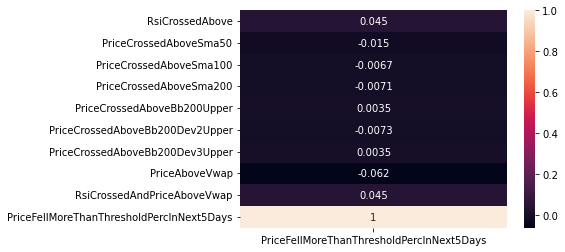

In [125]:
sns.heatmap(
  daily_data[ \
    (daily_data[CalculatedColumns.IsInDerivatives] == True) \
  ][flag_cols + [price_fall_flag_col]].corr()[['PriceFellMoreThanThresholdPercInNext5Days']]
, annot=True)

In [27]:
daily_data['RsiCrossedAndPriceAboveVwap'] = daily_data[CalculatedColumns.RsiCrossedAbove] & daily_data[CalculatedColumns.PriceAboveVwap]

In [28]:
daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True)  \
  ][['RsiCrossedAndPriceAboveVwap', price_fall_flag_col]].corr()

,RsiCrossedAndPriceAboveVwap,PriceFellMoreThanThresholdPercInNext5Days
RsiCrossedAndPriceAboveVwap,1.000000,0.045099
PriceFellMoreThanThresholdPercInNext5Days,0.045099,1.000000


In [71]:
print(daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
    (daily_data[price_fall_flag_col] == True)
  ][BaseColumns.Identifier].count())

print(daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
    (daily_data[price_fall_flag_col] == False) & \
    (daily_data[CalculatedColumns.RsiCrossedAbove] == False)
  ][BaseColumns.Identifier].count())

84438
249494


### Debug

In [ ]:
def format_datetime(dt_series, format):
    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date

    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = format)

    return dt_series

In [53]:
result = histDataProcessor.process(reader, {'from_date': datetime.date(2023, 7, 1), 'to_date': datetime.date.today()})
#identifier_grouped_data = result.get_identifier_grouped()
data = result.get_daily_data()

Started to read data
Reading data from 2023-08-09 to 2023-08-10
https://archives.nseindia.com/content/historical/EQUITIES/2023/AUG/cm10AUG2023bhav.csv.zip
The read operation timed out date(2023, 08, 10),
Saving data to file: ../../_data/processed/historical/Equities.csv
get_data took 46 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 1 seconds
Started periodic calculation for Month
add_monthly_growth_calc took 3 seconds
Started periodic calculation for Year
add_yearly_growth_calc took 1 seconds
process took 51 seconds


In [58]:
_time_window = 14

def calculate_wsm_average(raw_data, data, avg_col_name, abs_col_name):
  step = 1
  for i, row in enumerate(data[avg_col_name].iloc[_time_window + step:]):
    raw_data.at[data.index[i + _time_window + step], avg_col_name] =\
      (data[avg_col_name].iloc[i + _time_window] *
      (_time_window - step) +
      data[abs_col_name].iloc[i + _time_window + step])\
      / _time_window

In [62]:
identifier_grouped_data = data.groupby(BaseColumns.Identifier)
data[CalculatedColumns.ClosePriceDiff] = identifier_grouped_data[BaseColumns.Close].transform(lambda x: x.diff(1))
data[CalculatedColumns.Gain] = identifier_grouped_data[CalculatedColumns.ClosePriceDiff].transform(lambda x: x.clip(lower=0).round(2))
data[CalculatedColumns.Loss] = identifier_grouped_data[CalculatedColumns.ClosePriceDiff].transform(lambda x: x.clip(upper=0).abs().round(2))

data[CalculatedColumns.ClosePriceDiff].fillna(0)
data[CalculatedColumns.Gain].fillna(0)
data[CalculatedColumns.Loss].fillna(0)

# Get initial Averages
data[CalculatedColumns.AvgGain] = identifier_grouped_data[CalculatedColumns.Gain].transform(lambda x: 
                                    x.rolling(window=_time_window, min_periods=_time_window).mean())
data[CalculatedColumns.AvgLoss] = identifier_grouped_data[CalculatedColumns.Loss].transform(lambda x: 
                                    x.rolling(window=_time_window, min_periods=_time_window).mean())

for identifier in data['Identifier'].unique():
  calculate_wsm_average(data, identifier_grouped_data.get_group(identifier), CalculatedColumns.AvgGain, CalculatedColumns.Gain) 
  calculate_wsm_average(data, identifier_grouped_data.get_group(identifier), CalculatedColumns.AvgLoss, CalculatedColumns.Loss)

data[CalculatedColumns.RelativeStrength] = data[CalculatedColumns.AvgGain] / data[CalculatedColumns.AvgLoss]
data[CalculatedColumns.RelativeStrengthIndex] = 100 - (100 / (1.0 + data[CalculatedColumns.RelativeStrength]))

In [64]:
data[data[BaseColumns.Identifier] == 'TVSMOTOR'].tail(5)[[BaseColumns.Date, CalculatedColumns.RelativeStrengthIndex]]

,Date,Rsi
42317,2023-08-03,56.345408
44033,2023-08-04,51.629586
45742,2023-08-07,49.179718
50319,2023-08-08,46.982477
51286,2023-08-09,51.312888
